# PART A : Training from scratch

In [1]:
import os
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from torch.utils.data import random_split

# Image size
image_size = 224

# Count images function
def count_images_in_folder(root_dir):
    total_count = 0
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            total_count += len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
    return total_count

# Paths
train_path = "/kaggle/input/assign2-data/inaturalist_12K/train"
val_path = "/kaggle/input/assign2-data/inaturalist_12K/val"

# Count original images
train_count = count_images_in_folder(train_path)
val_count = count_images_in_folder(val_path)

print(f"Total training images (before split): {train_count}")
print(f"Total validation images: {val_count}")

Total training images (before split): 9999
Total validation images: 2000


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Device transfer function
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Dataset preparation function
def prepare_datasets(train_path, val_path, data_augmentation='No', test_split_ratio=0.2):
    # Transforms
    train_transforms = [Resize((image_size, image_size)), ToTensor()]
    if data_augmentation == 'Yes':
        train_transforms.insert(1, RandomHorizontalFlip())
        train_transforms.insert(2, RandomRotation(10))
        
    train_transform = Compose(train_transforms)
    val_transform = Compose([Resize((image_size, image_size)), ToTensor()])

    # Load full training dataset
    full_train_data = ImageFolder(root=train_path, transform=train_transform)

    # Split train into train and test
    total_size = len(full_train_data)
    test_size = int(test_split_ratio * total_size)
    train_size = total_size - test_size

    train_data, test_data = random_split(full_train_data, [train_size, test_size])

    # Load validation dataset (unchanged)
    validation_data = ImageFolder(root=val_path, transform=val_transform)

    return train_data, test_data, validation_data, full_train_data.classes

# Call the function
train_data, test_data, validation_data, class_names = prepare_datasets(train_path, val_path, data_augmentation='Yes')

# Print stats
print(f"Number of training images (after split): {len(train_data)}")
print(f"Number of testing images: {len(test_data)}")
print(f"Number of validation images: {len(validation_data)}")
print(f"Class names: {class_names}")

Number of training images (after split): 8000
Number of testing images: 1999
Number of validation images: 2000
Class names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


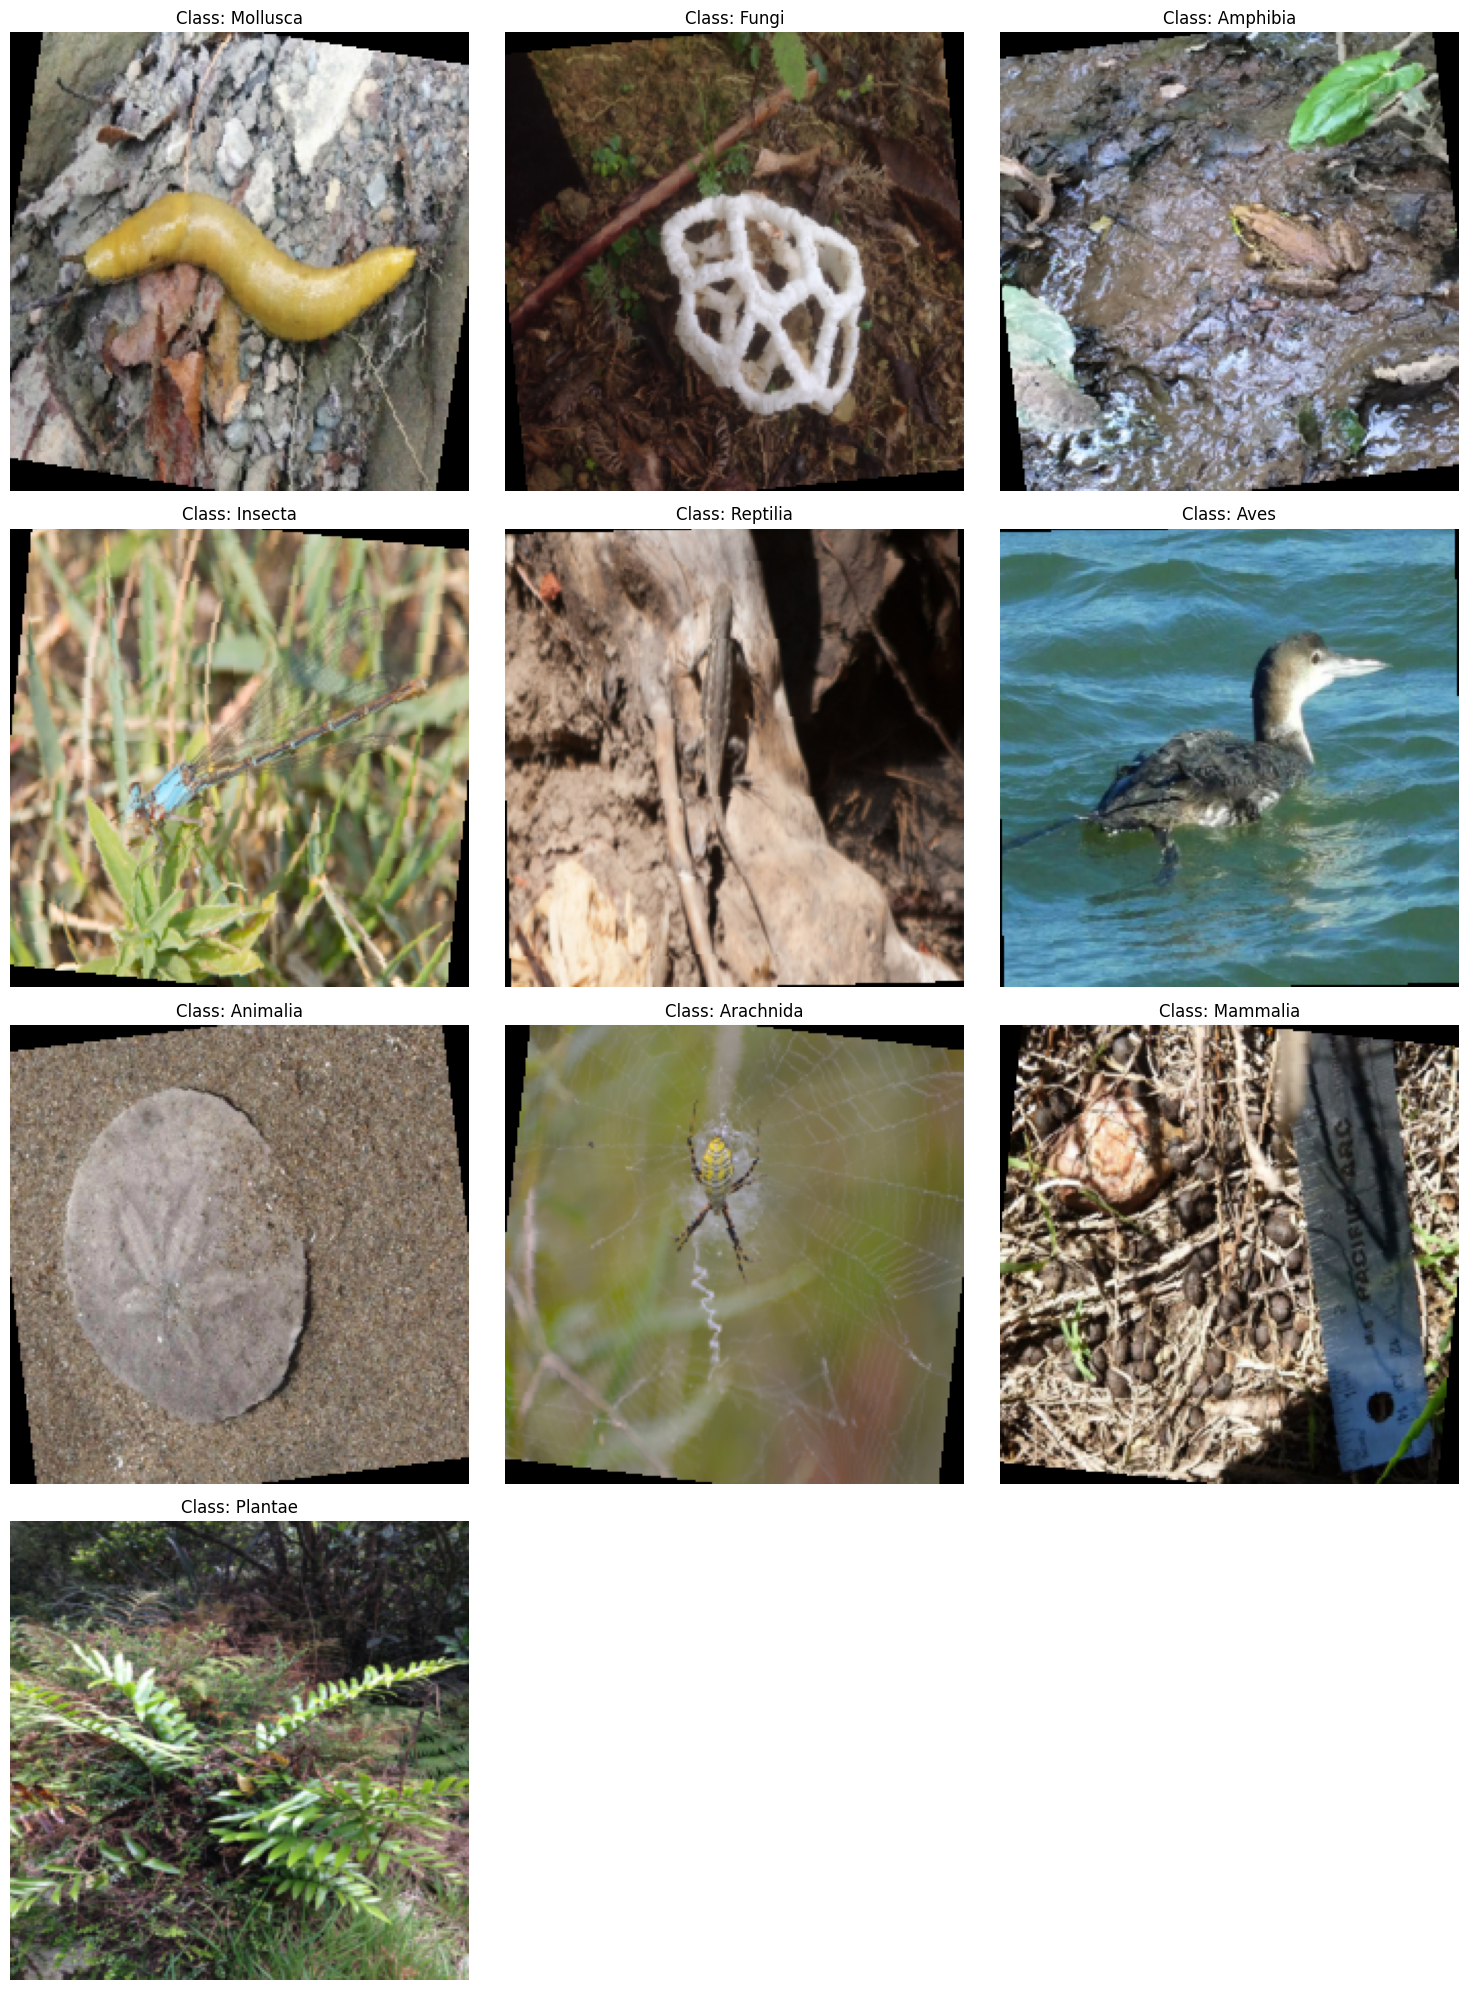

In [4]:
# show_images(train_data, n=10)

def show_images(subset, class_names, n=9, images_per_row=3):
    """
    Display one image per class from a Subset (train/test).

    Args:
        subset (torch.utils.data.Subset): The dataset subset to visualize images from.
        class_names (list): List of class names from ImageFolder.
        n (int): Number of unique class images to display.
        images_per_row (int): Number of images to display per row in the grid layout.

    Returns:
        None. Displays a matplotlib plot of images with class names as titles.
    """
    class_to_indices = defaultdict(list)

    for subset_idx, original_idx in enumerate(subset.indices):
        _, label = subset.dataset.samples[original_idx]
        class_to_indices[label].append(subset_idx)

    selected_classes = random.sample(list(class_to_indices.keys()), min(n, len(class_to_indices)))
    rows = (len(selected_classes) + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(rows, images_per_row, figsize=(5 * images_per_row, 5 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax in axes:
        ax.axis('off')

    for i, class_idx in enumerate(selected_classes):
        img_subset_idx = random.choice(class_to_indices[class_idx])
        img, label = subset[img_subset_idx]
        img = img.permute(1, 2, 0)  # Convert CHW to HWC
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[label]}", fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_data, class_names, n=10, images_per_row=3)

In [5]:
class CNNModel(nn.Module):
    def __init__(self,
                 input_channels=3,
                 num_filter=[32, 64, 128, 256, 512],
                 filter_size=3,
                 activation=nn.ReLU(),
                 stride=1,
                 padding=1,
                 pool_size=2,
                 fc_size=256,
                 num_classes=10,
                 dropout=0,
                 batch_normalization='Yes'):

        super(CNNModel, self).__init__()

        self.activation = activation
        self.batch_norm = batch_normalization == 'Yes'
        self.dropout = dropout

        layers = []
        in_channels = input_channels

        # 5 Convolutional blocks
        for out_channels in num_filter:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, stride=stride, padding=padding))
            if self.batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation)
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        # Calculate the flattened feature map size after conv layers
        # Assuming input image is 224x224
        def conv_output_size(size, filter_size=filter_size, stride=stride, padding=padding, pool=pool_size, layers=5):
            for _ in range(layers):
                size = (size + 2 * padding - filter_size) // stride + 1
                size = size // pool  # max pooling
            return size

        final_size = conv_output_size(224)
        flattened_dim = num_filter[-1] * final_size * final_size

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_size, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [6]:
# Create the model instance with default settings
model = CNNModel()

# Move model to device
model = model.to(device)

# Print the model architecture
print(model)

CNNModel(
  (activation): ReLU()
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [7]:

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # you can tune learning rate

# DataLoader for train and val.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

from tqdm import tqdm

# Accuracy helper
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item()

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = to_device((images, labels), device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        running_corrects += accuracy(outputs, labels)
        total_samples += images.size(0)

        # Update tqdm
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / total_samples
    train_acc = running_corrects / total_samples
    return train_loss, train_acc

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating", leave=False)
        for images, labels in loop:
            images, labels = to_device((images, labels), device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += accuracy(outputs, labels)
            total_samples += images.size(0)

            loop.set_postfix(loss=loss.item())

    val_loss = running_loss / total_samples
    val_acc = running_corrects / total_samples
    return val_loss, val_acc

In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")



Epoch [1/10]


Train Loss: 2.0786, Train Acc: 0.2640
Val   Loss: 1.9182, Val   Acc: 0.3250

Epoch [2/10]


Train Loss: 1.9070, Train Acc: 0.3314
Val   Loss: 1.8881, Val   Acc: 0.3390

Epoch [3/10]


Train Loss: 1.8137, Train Acc: 0.3658
Val   Loss: 1.8273, Val   Acc: 0.3730

Epoch [4/10]


Train Loss: 1.7538, Train Acc: 0.3834
Val   Loss: 1.8178, Val   Acc: 0.3705

Epoch [5/10]


Train Loss: 1.6897, Train Acc: 0.4116
Val   Loss: 1.7810, Val   Acc: 0.3745

Epoch [6/10]


Train Loss: 1.6411, Train Acc: 0.4244
Val   Loss: 1.7910, Val   Acc: 0.4025

Epoch [7/10]


Train Loss: 1.5903, Train Acc: 0.4452
Val   Loss: 1.7214, Val   Acc: 0.4160

Epoch [8/10]


Train Loss: 1.5503, Train Acc: 0.4602
Val   Loss: 1.6624, Val   Acc: 0.4285

Epoch [9/10]


Train Loss: 1.4942, Train Acc: 0.4796
Val   Loss: 1.7027, Val   Acc: 0.4135

Epoch [10/10]


Train Loss: 1.4513, Train Acc: 0.4938
Val   Loss: 1.7308, Val   Acc: 0.4060


In [9]:
!pip install wandb

In [10]:
import wandb
from types import SimpleNamespace


In [11]:
wandb.login(key='43cc4a6022bf573f56ea92522b3e44bac7bd28b6')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ajay-madkami-iitm (ajay-madkami-iitm-indian-institute-of-technology-mad). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Create a Sweep Configuration**

In [12]:
sweep_config = {
    'method': 'random',  # random > grid for smart exploration
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
            'values': [
                [32]*5,
                [64]*5,
                [32, 64, 128, 256, 512]
            ]
        },
        'activation': {
            'values': ['ReLU', 'GELU', 'SiLU', 'Mish']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'batch_norm': {
            'values': ['Yes', 'No']
        },
        'data_augmentation': {
            'values': ['Yes', 'No']
        },
        'learning_rate': {
            'values': [1e-3, 5e-4, 1e-4]
        },
        'fc_size': {
            'values': [128, 256]
        }
    }
}


In [13]:
import wandb
from torch.nn import ReLU, GELU, SiLU, Mish

# Map string to actual activation function
ACTIVATION_MAP = {
    'ReLU': ReLU(),
    'GELU': GELU(),
    'SiLU': SiLU(),
    'Mish': Mish()
}

def train_sweep():
    wandb.init()
    config = wandb.config

    activation_fn = ACTIVATION_MAP[config.activation]
    model = CNNModel(
        input_channels=3,
        num_filter=config.num_filters,
        filter_size=3,
        activation=activation_fn,
        stride=1,
        padding=1,
        pool_size=2,
        fc_size=config.fc_size,
        num_classes=10,
        dropout=config.dropout,
        batch_normalization=config.batch_norm
    )
    model = to_device(model, device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # Prepare dataset with/without augmentation
    train_data_aug, val_data, _, _ = prepare_datasets(train_path, val_path, data_augmentation=config.data_augmentation)
    train_loader = DataLoader(train_data_aug, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)

    for epoch in range(1,2):  # keep it small to reduce sweep time
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })


In [14]:
# Create sweep
sweep_id = wandb.sweep(sweep_config, project="Assignment2")
# Run it
wandb.agent(sweep_id, function=train_sweep, count=1)  # or more if you want


Create sweep with ID: tb9ctxg8
Sweep URL: https://wandb.ai/ajay-madkami-iitm-indian-institute-of-technology-mad/Assignment2/sweeps/tb9ctxg8


wandb: Agent Starting Run: 5d9k2ua0 with config:
wandb: 	activation: GELU
wandb: 	batch_norm: No
wandb: 	data_augmentation: Yes
wandb: 	dropout: 0.3
wandb: 	fc_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_filters: [32, 64, 128, 256, 512]


In [15]:
# Model and optimizer setup
activation_fn = Mish()
model = CNNModel(
    input_channels=3,
    num_filter=[32, 64, 128, 256, 512],
    filter_size=3,
    activation=activation_fn,
    stride=1,
    padding=1,
    pool_size=2,
    fc_size=256,
    num_classes=len(class_names),
    dropout=0.2,
    batch_normalization=True
)
model = to_device(model, device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")


Epoch [1/10]


Train Loss: 2.2594, Train Acc: 0.1384
Test  Loss: 2.2150, Test  Acc: 0.1956

Epoch [2/10]


Train Loss: 2.1206, Train Acc: 0.2319
Test  Loss: 2.0178, Test  Acc: 0.2996

Epoch [3/10]


Train Loss: 2.0059, Train Acc: 0.2953
Test  Loss: 1.9915, Test  Acc: 0.3052

Epoch [4/10]


Train Loss: 1.9514, Train Acc: 0.3127
Test  Loss: 1.9397, Test  Acc: 0.3167

Epoch [5/10]


Train Loss: 1.9070, Train Acc: 0.3292
Test  Loss: 1.9420, Test  Acc: 0.3217

Epoch [6/10]


Train Loss: 1.8664, Train Acc: 0.3417
Test  Loss: 1.9070, Test  Acc: 0.3337

Epoch [7/10]


Train Loss: 1.8537, Train Acc: 0.3510
Test  Loss: 1.9010, Test  Acc: 0.3377

Epoch [8/10]


Train Loss: 1.8146, Train Acc: 0.3663
Test  Loss: 1.8727, Test  Acc: 0.3452

Epoch [9/10]


Train Loss: 1.7834, Train Acc: 0.3754
Test  Loss: 1.8865, Test  Acc: 0.3477

Epoch [10/10]


Train Loss: 1.7631, Train Acc: 0.3837
Test  Loss: 1.8902, Test  Acc: 0.3417


wandb: WARNING Ignoring project 'Assignment2' when running a sweep.


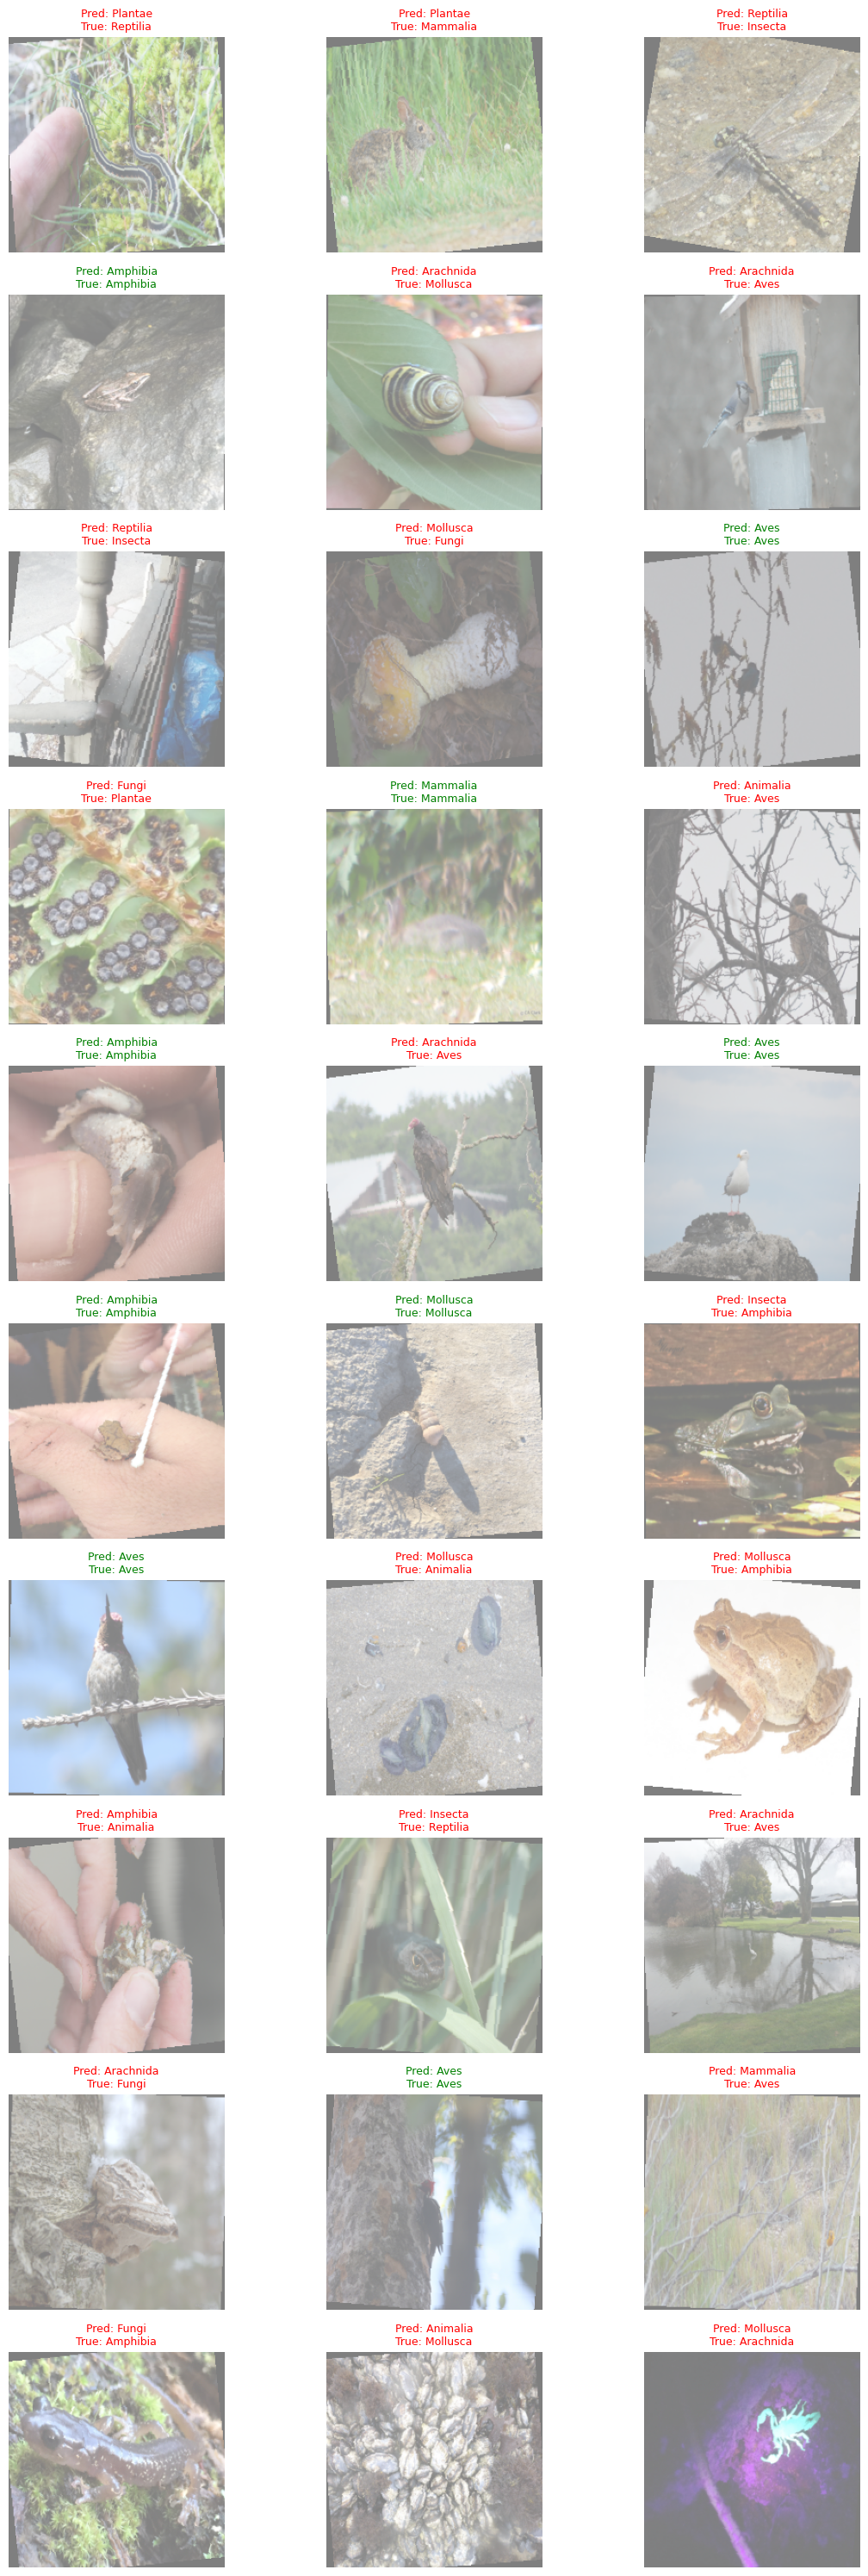

In [16]:

from io import BytesIO
from PIL import Image  # Add this import

# ----------------------
# Initialize wandb
# ----------------------
wandb.init(project="Assignment2", name="prediction_grid_run")

# ----------------------
# Helper: imshow
# ----------------------
def imshow(img):
    img = img.permute(1, 2, 0)  # CHW to HWC
    img = img * 0.5 + 0.5  # unnormalize if needed
    return img.cpu().numpy()

# ----------------------
# Plot and log to wandb
# ----------------------
def plot_predictions_grid(model, test_loader, class_names, device):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(10, 3, figsize=(12, 30))
    axes = axes.flatten()

    for i in range(30):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        pred_label = class_names[preds[i]]
        true_label = class_names[labels[i]]
        correct = pred_label == true_label

        color = 'green' if correct else 'red'
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=9)
        ax.axis('off')

    plt.tight_layout()

    # Save to buffer and convert to PIL Image
    buf = BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_pil = Image.open(buf)

    # Log to wandb
    wandb.log({"Prediction Grid": wandb.Image(img_pil)})

    plt.show()

# ----------------------
# Run the visualization
# ----------------------
plot_predictions_grid(model, test_loader, class_names, device)

# Optionally finish wandb run
wandb.finish()

# PART B : Fine-tuning a pre-trained model


In [17]:

from torchvision import datasets, transforms, models
from torchvision import models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm

In [18]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")





def pretrain_model(model_name, freeze_percent):
    if model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        raise ValueError("Model not supported")

    # Modify final classification layer for 10 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)

    # Freeze bottom freeze_percent of parameters
    all_params = list(model.parameters())
    num_params_to_freeze = int(len(all_params) * freeze_percent)
    for i, param in enumerate(all_params):
        param.requires_grad = i >= num_params_to_freeze

    return model.to(device)


Using device: cuda


In [19]:
def data_load(data_dir, data_augmentation, batch_size):
    image_size = 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if data_augmentation == 'Yes':
        train_transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    val_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_data = datasets.ImageFolder(os.path.join(data_dir, '/kaggle/input/assign2-data/inaturalist_12K/train'), transform=train_transforms)
    val_data = datasets.ImageFolder(os.path.join(data_dir, '/kaggle/input/assign2-data/inaturalist_12K/val'), transform=val_transforms)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader


In [20]:
def train_on_train_data(model, train_loader, optimizer, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return train_loss / total, acc


In [21]:
def test_on_valid_data(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return val_loss / total, acc

In [22]:
def model_train(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_on_train_data(model, train_loader, optimizer, criterion)
        val_loss, val_acc = test_on_valid_data(model, val_loader, criterion)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

sweep_config = {
    'method': 'random', #'bayes',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'values': [1e-4, 1e-3, 1e-2]},
        'optimizer': {'values': ['adam', 'sgd', 'rmsprop']},
        'weight_decay': {'values': [0.0, 1e-4, 1e-3]},
        'batch_size': {'values': [32, 64]},
        'data_augmentation': {'values': ['Yes', 'No']},
        'freeze_percent': {'values': [0.3, 0.5, 0.8]}
    }
}

In [23]:

def main():
    with wandb.init(project="resnet50-finetune", config=sweep_config['parameters']):
        config = wandb.config

        model = pretrain_model(
            model_name='resnet50',
            freeze_percent=config.freeze_percent
        )

        train_loader, val_loader = data_load("dataset", config.data_augmentation, config.batch_size)

        criterion = nn.CrossEntropyLoss()

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
        elif config.optimizer == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        model_train(model, train_loader, val_loader, optimizer, criterion, epochs=5)


In [ ]:
# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="Assignment2")
wandb.agent(sweep_id, function=main, count = 20)


Create sweep with ID: 508pyx91
Sweep URL: https://wandb.ai/ajay-madkami-iitm-indian-institute-of-technology-mad/Assignment2/sweeps/508pyx91


wandb: Agent Starting Run: hdtessst with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: No
wandb: 	freeze_percent: 0.8
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignoring project 'resnet50-finetune' when running a sweep.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]
Validation: 100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


wandb: Agent Starting Run: 2691oogx with config:
wandb: 	batch_size: 64
wandb: 	data_augmentation: Yes
wandb: 	freeze_percent: 0.3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: WARNING Ignoring project 'resnet50-finetune' when running a sweep.


Validation: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


wandb: Agent Starting Run: bnpipqlh with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: No
wandb: 	freeze_percent: 0.5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignoring project 'resnet50-finetune' when running a sweep.


Validation: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


wandb: Agent Starting Run: 1g47t0mq with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: No
wandb: 	freeze_percent: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: WARNING Ignoring project 'resnet50-finetune' when running a sweep.


Validation: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s]


wandb: Agent Starting Run: z1ngic7z with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: Yes
wandb: 	freeze_percent: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignoring project 'resnet50-finetune' when running a sweep.


Validation: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]


wandb: Agent Starting Run: 8l81mkyf with config:
wandb: 	batch_size: 64
wandb: 	data_augmentation: Yes
wandb: 	freeze_percent: 0.5
wandb: 	learning_rate: 0.01
